In [683]:
import h5py    
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
from IPython.display import clear_output
import multiprocessing as mp
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
# figsize(10,8)



In [684]:
import h5py as h5
l1 = h5.File('./data/CFIS_L1_NGDCS20170619t184335_cal_2018_v2.h5','r')
spectra_ = np.array(l1['camera/radiances'][:])
wlSize=2048
disp = np.asarray([-1.2553e-6,0.0201,735.4572])
ind = np.linspace(1,wlSize,wlSize)
wlGrid_ = np.polyval(disp,ind )
wlGrid = wlGrid_[(wlGrid_>747)&(wlGrid_<756)]
spectra_ = spectra_[:,(wlGrid_>747)&(wlGrid_<756),:]
l1.close()



In [685]:
# Read in tabulated pre-computed dataset.
sun = np.loadtxt('data/solar_merged_20160127_600_26316_100.out')
# interpolate to common grid in wavelength (not wavenumber), use 0.002nm sampling here
res = 0.002
# create wavelength grid in nm
wl = np.arange(727,776,res)
# Solar transmission spectrum, resample to wavelength grid (from wavenumber):
f = interp1d(1.e7/sun[:,0], sun[:,1])
Tsun = f(wl)
co = 2.355
T_cfis = gaussian_filter1d(Tsun, 0.07/res/co)




In [686]:
wl.shape

(24500,)

In [687]:
SIF_shape.shape

(501,)

In [688]:
f1 = h5py.File('./data/PS_SIF_map_easy.h5','r')    
f1_keys=list(f1.keys())
list(f1.keys())
SIF_shape_ = f1['SIF_shape'][:] # (437,)

wl_sif = f1['wlGrid'][:] # dwlGrid = 0.03 (437,)
f = interp1d(wl_sif,SIF_shape_,fill_value="extrapolate")
SIF_shape = f(wlGrid)
f1.close()

In [689]:
co = 2.355


class Setup:
    pass
mySetup = Setup()

mySetup.FWHM = 0.07
# wo = np.where((wl_solarSpectrum>743)&(wl_solarSpectrum<757))[0]
# mySetup.wl_so = wl

mySetup.wl_in = wl
mySetup.wl_out = wlGrid
mySetup.res = 0.01 # wlGrid[1:]-wlGrid[0:-1]




In [690]:
# reference solar spectrum
# Lo = Tsun*s_base/np.pi # mW/M2/SR/UM
Tsun = T_cfis.copy()
Lo = Tsun/np.pi 

In [1241]:

def forward_model_shift(x,b,compK = False):
    poly_wl = x[0:3]
    b.FWHM = x[3]
    poly = x[-4:-1]

    a = x[-1]
#     c1 = x[0]; p0 = x[1]; p1 = x[2]; p2 = x[3]; a = x[4]
    

    Lo_conv = gaussian_filter1d(Lo,b.FWHM/b.res/co)
    
    detPixels = len(b.wl_in)
    grid = np.arange(0,detPixels,1)-detPixels/2.
#     wl_shifted = grid+c1 # b.nu_out in the example 8
    wl_shifted = np.polyval(poly_wl,grid)
    
    finter1 = interp1d(grid, Lo_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_conv_shifted = finter1(wl_shifted)
    
    finter2 = interp1d(b.wl_in, Lo_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_1 = finter2(b.wl_out)# output Lo
    
    dwl = b.wl_out-np.mean(b.wl_out)
    F_ref_nosif = Lo_1*np.polyval(poly,dwl)
    F_forward = F_ref_nosif+a*SIF_shape

    if compK:
        K = np.zeros((len(b.wl_out),len(x)))
#         dx = [5e-6,5e-6,5e-6]
        dx = [1e-6,1e-6,1e-6,1e-6]
        for i in range(3):
            poly_wl2 = poly_wl.copy()
            poly_wl2[i] = poly_wl[i]+dx[i]
#             c1_2 = c1 + dx
            Lo_2 = finter1(np.polyval(poly_wl2,grid))
            finter3 = interp1d(b.wl_in, Lo_2,kind='linear', fill_value=np.NaN,bounds_error=False)
            Lo_2 = finter3(b.wl_out)
            FF = Lo_2*np.polyval(poly,dwl)+a*SIF_shape

            K[:,i] = (FF-F_forward)/dx[i]# partial I partial c1
        
        K[:,-4] = Lo_1*dwl**2 # partial I partial p0
        
        K[:,-3] = Lo_1*dwl# partial I partial p1
        K[:,-2] = Lo_1# partial I partial p2
        K[:,-1] = SIF_shape# partial I partial a
        
        FWHM2 = b.FWHM+dx[3]
        Lo_conv2 = gaussian_filter1d(Lo,FWHM2/b.res/co)
    
        finter1_2 = interp1d(grid, Lo_conv2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_conv_shifted_2 = finter1_2(wl_shifted)

        finter2_2 = interp1d(b.wl_in, Lo_conv_shifted_2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_1_2 = finter2_2(b.wl_out)# output Lo

        F_ref_nosif_2 = Lo_1_2*np.polyval(poly,dwl)
        F_forward_2 = F_ref_nosif_2+a*SIF_shape
        K[:,3] = (F_forward_2-F_forward)/dx[3]
    if compK:
        return F_forward,K
    else:
        return F_forward


def iterate_fit(x0,b,F,n_itr=500,thrs = 1e-3):
    chi2_r_old = 1e9
    DOF = len(F)-len(x0)
    invSe = noise_model(F)
    F0_guess,K = forward_model_shift(x0,b,compK=True)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x = x0+ Gain.dot(F-F0_guess)
    F0,K = forward_model_shift(x,b,compK=True)
    chi2 = np.sum((F0-F0_guess)**2*np.diag(invSe))
    chi2_r = chi2/DOF
    print(xa)
    chi2_r_itr =[];x_linear_itr=[];sif_1sigma_itr=[]
    for i in range(n_itr):
        
        
#         #F0,K = forward_model_shift(x,b,compK=True)
#         #### uncomment the below if no prior
#         Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
        
#         x_plus1 = x+ Gain.dot(F-F0)
#         ####
        
        ####
# #         add prior
        x_plus1 = x + np.linalg.inv(K.T.dot(invSe).dot(K)+invSa).dot(K.T.dot(invSe).dot(F-F0)-invSa.dot(x-xa))
        print(x_plus1.shape)
        ####
        S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
        sif_1sigma = np.sqrt(S_posterior[-1,-1])
        #F2 = forward_model_shift(x_plus1,b)
        F2,K_new = forward_model_shift(x_plus1,b,compK=True)
        chi2 = np.sum((F2-F)**2*np.diag(invSe))
        chi2_r = chi2/DOF
        chi2_r_itr.append(chi2_r)
        x_linear_itr.append(x_plus1)
        sif_1sigma_itr.append(sif_1sigma)
        if abs(chi2_r-chi2_r_old) < thrs:
            print('iteration %d' %i)
            break
        else:
            x = x_plus1.copy() 
            chi2_r_old = chi2_r.copy()
            F0 = F2.copy()
            K = K_new.copy()
            
        
    return x_linear_itr,sif_1sigma_itr,chi2_r_itr



def noise_model(F):
# '''This is the noise model for each point on the map'''
# '''F is the measured radiance, which is a function of wavelength'''
    
    invSe = np.zeros((len(F),len(F)))
    
    noise = np.sqrt(F)/40
    
    invSe=np.diag(1./(noise**2) )
    return invSe


def linear_fit(F):
    invSe = noise_model(F)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x_linear = Gain.dot(F)
    S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
    sif_1sigma = np.sqrt(S_posterior[-1,-1])
    chi2 = np.sum((np.dot(K,x_linear)-F)**2*np.diag(invSe))
    chi2_r = chi2/(len(F)-len(x_linear))
    return x_linear,sif_1sigma,chi2_r

In [1475]:
F_forward,K = forward_model_shift([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,compK=True)

x_linear,sif_1sigma,chi2_r = linear_fit(spectra)


In [1476]:
#add prior info
xa =[0,0,0,0.07,0,0,0,x_linear[-1]] #[0,0,0,0,0,0,10]

invSa = np.zeros((len(xa),len(xa)))


invSa[3,3] = 1/(0.008**2)
invSa[-1,-1] = 1/(0.1**2)

In [1477]:
len(xa)

8

In [1478]:
x_linear

array([ 2.83371286e-07, -5.58232458e-04, -1.02665646e+01,  2.62062291e-01,
        1.20184573e-01,  3.98864864e-01,  2.30709040e+02,  8.14349624e-01])

In [1479]:
chi2_r

0.936338405512958

Text(0.5,1,'linear retrievel one step')

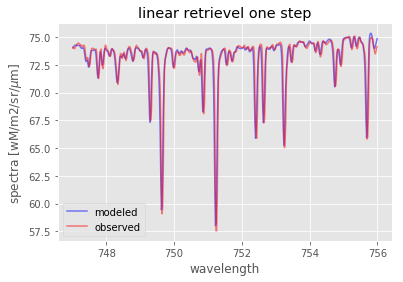

In [1480]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('linear retrievel one step')

Text(0.5,1,'F_forward-F_observed')

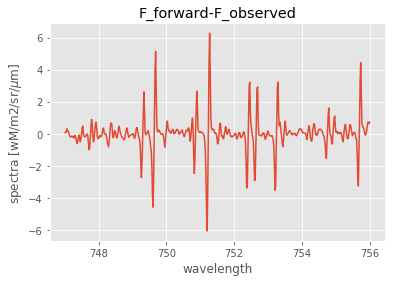

In [1481]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [1482]:
ma,mb,mc = iterate_fit([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)

[0, 0, 0, 0.07, 0, 0, 0, 0.814349624372511]
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(

In [1483]:
len(ma)

200

In [1487]:

np.array(ma)[:-1]

array([0.97939035, 0.54241544, 0.50832798, 0.54261049, 0.5084271 ,
       0.54257226, 0.50842796, 0.54257017, 0.50842797, 0.54257001,
       0.50842797, 0.54257   , 0.50842797, 0.54257   , 0.50842797,
       0.54257   , 0.50842797, 0.54257   , 0.50842797, 0.54257   ,
       0.50842797, 0.54257   , 0.50842797, 0.54257   , 0.50842797,
       0.54257   , 0.50842797, 0.54257   , 0.50842797, 0.54257   ,
       0.50842797, 0.54257   , 0.50842797, 0.54257   , 0.50842797,
       0.54257   , 0.50842797, 0.54257   , 0.50842797, 0.54257   ,
       0.50842797, 0.54257   , 0.50842797, 0.54257   , 0.50842797,
       0.54257   , 0.50842797, 0.54257   , 0.50842797, 0.54257   ,
       0.50842797, 0.54257   , 0.50842797, 0.54257   , 0.50842797,
       0.54257   , 0.50842797, 0.54257   , 0.50842797, 0.54257   ,
       0.50842797, 0.54257   , 0.50842797, 0.54257   , 0.50842797,
       0.54257   , 0.50842797, 0.54257   , 0.50842797, 0.54257   ,
       0.50842797, 0.54257   , 0.50842797, 0.54257   , 0.50842

In [1494]:

np.array(ma)[:,3]

array([0.0461311 , 0.01165912, 0.04612955, 0.01133269, 0.04611354,
       0.01134318, 0.0461125 , 0.01134398, 0.04611242, 0.01134405,
       0.04611241, 0.01134405, 0.04611241, 0.01134405, 0.04611241,
       0.01134405, 0.04611241, 0.01134405, 0.04611241, 0.01134405,
       0.04611241, 0.01134405, 0.04611241, 0.01134405, 0.04611241,
       0.01134405, 0.04611241, 0.01134405, 0.04611241, 0.01134405,
       0.04611241, 0.01134405, 0.04611241, 0.01134405, 0.04611241,
       0.01134405, 0.04611241, 0.01134405, 0.04611241, 0.01134405,
       0.04611241, 0.01134405, 0.04611241, 0.01134405, 0.04611241,
       0.01134405, 0.04611241, 0.01134405, 0.04611241, 0.01134405,
       0.04611241, 0.01134405, 0.04611241, 0.01134405, 0.04611241,
       0.01134405, 0.04611241, 0.01134405, 0.04611241, 0.01134405,
       0.04611241, 0.01134405, 0.04611241, 0.01134405, 0.04611241,
       0.01134405, 0.04611241, 0.01134405, 0.04611241, 0.01134405,
       0.04611241, 0.01134405, 0.04611241, 0.01134405, 0.04611

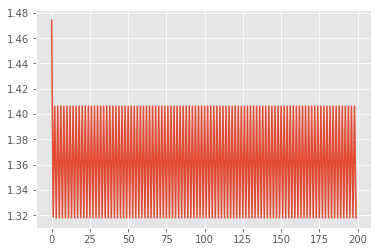

In [1488]:
plt.plot(mc)

In [1489]:
ma

[array([1.37477946e-07, 9.99386930e-01, 3.01848562e+01, 4.61311015e-02,
        1.20787469e-01, 4.16486613e-01, 2.30203930e+02, 9.79390351e-01]),
 array([1.29157693e-07, 9.99462346e-01, 3.00841222e+01, 1.16591197e-02,
        1.19605334e-01, 3.70054849e-01, 2.31535491e+02, 5.42415444e-01]),
 array([1.22148850e-07, 9.99464674e-01, 3.00958325e+01, 4.61295488e-02,
        1.19514851e-01, 3.66434746e-01, 2.31639270e+02, 5.08327979e-01]),
 array([1.35720524e-07, 9.99453594e-01, 3.00828682e+01, 1.13326867e-02,
        1.19607064e-01, 3.70065374e-01, 2.31534883e+02, 5.42610494e-01]),
 array([1.21656847e-07, 9.99464874e-01, 3.00962394e+01, 4.61135422e-02,
        1.19515532e-01, 3.66447366e-01, 2.31638967e+02, 5.08427097e-01]),
 array([1.35755210e-07, 9.99453563e-01, 3.00828443e+01, 1.13431797e-02,
        1.19606937e-01, 3.70061140e-01, 2.31534999e+02, 5.42572256e-01]),
 array([1.21654799e-07, 9.99464875e-01, 3.00962409e+01, 4.61124967e-02,
        1.19515538e-01, 3.66447468e-01, 2.31638964e+

In [1490]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

Text(0.5,1,'non-linear retrievel last step')

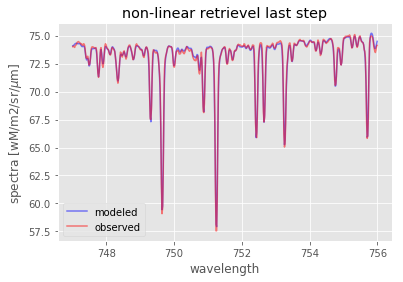

In [1491]:

plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

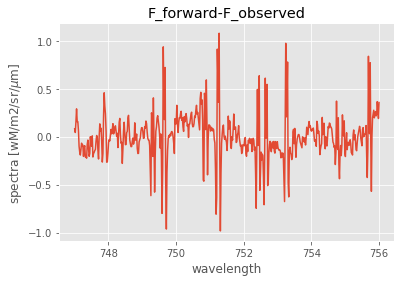

In [1492]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [1404]:
spectra2 =spectra_[220,:,550]
F_forward,K = forward_model_shift([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,compK=True)
x_linear,sif_1sigma,chi2_r = linear_fit(spectra2)
#add prior info
xa =[0,0,0,0.07]+list(x_linear[4:]) #[0,0,0,0,0,0,10]
invSa = np.zeros((len(xa),len(xa)))
invSa[3,3] = 1/(0.001**2)
invSa[-1,-1] = 1/(1**2)

Text(0.5,1,'non-linear retrievel last step')

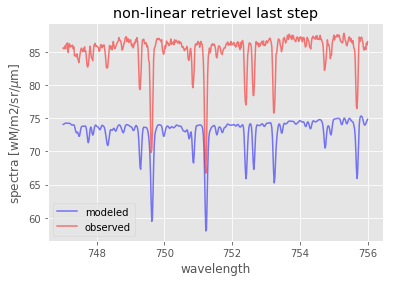

In [933]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra2,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

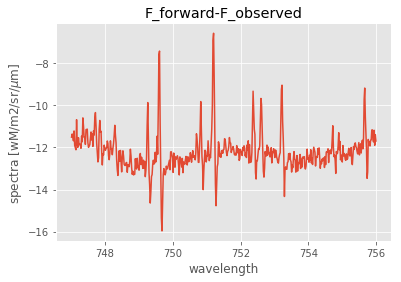

In [934]:
plt.plot(mySetup.wl_out,F_forward-spectra2)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [935]:

ma,mb,mc =iterate_fit([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,spectra2,n_itr=200,thrs=1e-10)

[0, 0, 0, 0.07, 0.03179848714735678, 0.5463863328779459, 268.0266493695314, 1.5966216966664213]
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)

In [936]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

In [937]:
ma

[array([ 1.41204278e-07,  9.98677066e-01,  4.54576280e+01,  6.94937943e-02,
         2.53420634e-02,  2.52016777e-01,  2.76467935e+02, -1.17581108e+00]),
 array([ 1.21869747e-07,  9.98688198e-01,  4.56038832e+01,  6.88508912e-02,
         2.45788878e-02,  2.17200660e-01,  2.77465182e+02, -1.50345808e+00]),
 array([ 1.21967005e-07,  9.98689315e-01,  4.55938900e+01,  6.88547512e-02,
         2.45667804e-02,  2.16651580e-01,  2.77481191e+02, -1.50871855e+00]),
 array([ 1.22158176e-07,  9.98688917e-01,  4.55943116e+01,  6.88546179e-02,
         2.45669661e-02,  2.16653000e-01,  2.77481117e+02, -1.50869378e+00]),
 array([ 1.22243461e-07,  9.98688998e-01,  4.55939705e+01,  6.88546229e-02,
         2.45668369e-02,  2.16653518e-01,  2.77481104e+02, -1.50868913e+00]),
 array([ 1.22090924e-07,  9.98689064e-01,  4.55943512e+01,  6.88546502e-02,
         2.45670062e-02,  2.16659107e-01,  2.77480949e+02, -1.50863860e+00]),
 array([ 1.22247850e-07,  9.98688987e-01,  4.55939674e+01,  6.88546182e-02,


In [938]:
np.array(ma)[:,-1]

array([-1.17581108, -1.50345808, -1.50871855, -1.50869378, -1.50868913,
       -1.5086386 , -1.50870148, -1.50863777, -1.50870165, -1.50863773,
       -1.50870166, -1.50863772, -1.50870166, -1.50863773, -1.50870166,
       -1.50863772, -1.50870167, -1.50863772, -1.50870167, -1.50863773,
       -1.50870167, -1.50863772, -1.50870166, -1.50863772, -1.50870166,
       -1.50863773, -1.50870166, -1.50863773, -1.50870166, -1.50863772,
       -1.50870166, -1.50863773, -1.50870166, -1.50863773, -1.50870166,
       -1.50863773, -1.50870166, -1.50863773, -1.50870167, -1.50863773,
       -1.50870166, -1.50863772, -1.50870167, -1.50863773, -1.50870167,
       -1.50863772, -1.50870166, -1.50863772, -1.50870166, -1.50863773,
       -1.50870166, -1.50863772, -1.50870167, -1.50863773, -1.50870166,
       -1.50863773, -1.50870166, -1.50863772, -1.50870167, -1.50863773,
       -1.50870166, -1.50863772, -1.50870167, -1.50863772, -1.50870166,
       -1.50863773, -1.50870166, -1.50863773, -1.50870166, -1.50

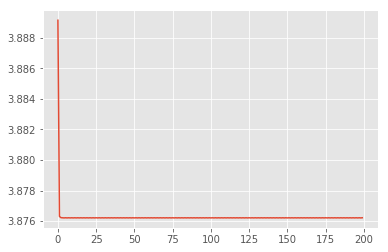

In [939]:
plt.plot(mc)

Text(0.5,1,'spectra 2 non-linear retrievel last step')

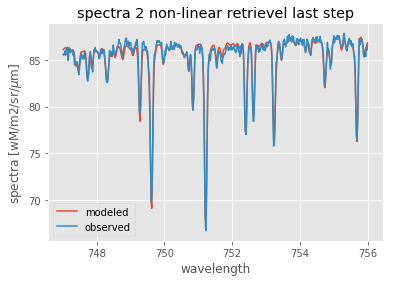

In [940]:

plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra2,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 non-linear retrievel last step')

Text(0.5,1,'spectra 2 F_forward-F_observed')

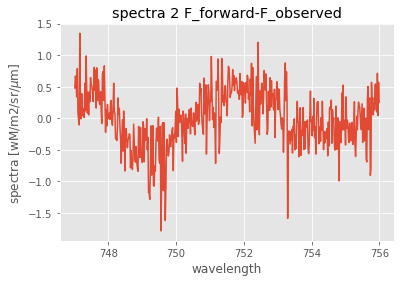

In [941]:
plt.plot(mySetup.wl_out,F_forward-spectra2)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 F_forward-F_observed')

In [780]:
np.array(ma)[:,-1]

array([0.60613397, 0.57964336, 0.57899602, 0.57900917, 0.57902131,
       0.57901923, 0.57901939, 0.57901937, 0.57901937, 0.57901938,
       0.57901938, 0.57901937, 0.57901937, 0.57901937, 0.57901938,
       0.57901937, 0.57901937, 0.57901937, 0.57901938, 0.57901937,
       0.57901937, 0.57901937, 0.57901937, 0.57901937, 0.57901937,
       0.57901937, 0.57901938, 0.57901937, 0.57901937, 0.57901937,
       0.57901937, 0.57901937, 0.57901937, 0.57901937])

In [782]:

SIF = []; SIF_1SIGMA = [];CHI2_R = []
for i in range(100,102):
    for j in range(10,20):
        spectra = spectra_[i,:,j]
        _,K = forward_model_shift([0,1,40]+[0.132,0.38,233.1,0],mySetup,compK=True)
        x_linear,sif_1sigma,chi2_r = linear_fit(spectra)
        #add prior info
        xa =[0,0,0]+list(x_linear[3:]) #[0,0,0,0,0,0,10]
        invSa = np.zeros((len(xa),len(xa)))
        invSa[6,6] = 1/(0.1**2)
        ma,mb,mc =iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)
        SIF.append(ma[-1][-1])
        SIF_1SIGMA.append(mb[-1])
        CHI2_R.append(mc[-1])
        

[0, 0, 0, 0.1409953240801538, 2.1123578725519243, 292.26325769990996, 9.214142847584453]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 50
[0, 0, 0, 0.16288541390148836, 1.187628739626063, 270.3364116510969, 7.4104112281385]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 45
[0, 0, 0, 0.16347580326241434, 1.8884529703998567, 324.93464313582706, 6.824767029525125]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 17
[0, 0, 0, 0.13631117962923986, 1.5671173902683044, 262.0256635444129, 7.309459157875423]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7

(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
[0, 0, 0, 0.16263224534368612, 1.3517916229317217, 293.2661706753395, 7.1748265794814134]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 101
[0, 0, 0, 0.1628550596571894, 0.7985245110069776, 2

In [110]:
SIF = np.reshape(np.array(SIF),(2,10))

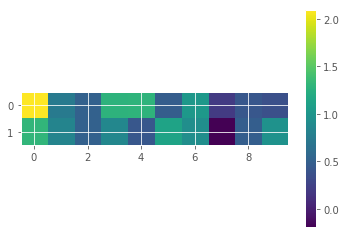

In [111]:
plt.imshow(np.array(SIF))
plt.colorbar()

In [108]:
SIF

array([[1.11705576, 0.5830816 , 0.60389113, 1.15996298, 1.02729951,
        0.55275171, 0.79666046, 0.39140188, 0.5566552 , 0.50727497],
       [0.7752244 , 0.65195165, 0.81342446, 0.99977152, 0.64872309,
        0.99044986, 0.86398036, 0.22664276, 0.69554782, 0.97136556]])

In [112]:
SIF

array([[ 2.09268259,  0.75080587,  0.51744511,  1.28318748,  1.29728309,
         0.47797077,  1.02917044,  0.20267548,  0.42839246,  0.36556143],
       [ 1.31247678,  0.84255759,  0.51732899,  0.86189353,  0.42641457,
         1.13372404,  0.93544833, -0.19239609,  0.48807547,  0.97136556]])